In [525]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as k
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

In [885]:
# Load MNIST dataset
MNIST = k.datasets.fashion_mnist.load_data()
#MNIST = k.datasets.mnist.load_data()
# Seperate dataset
training = MNIST[0]
X_train = training[0]
y_train = pd.Series(training[1], name="training targets")
testing = MNIST[1]
X_test = testing[0]
y_test = pd.Series(testing[1], name="testing targets")
# Keep only 1s and 0s for binary classification problem
y_train = y_train[(y_train == 2) | (y_train == 4)] // 2 - 1
X_train = X_train[y_train.index]
y_test = y_test[(y_test == 2) | (y_test == 4)] // 2 - 1
X_test = X_test[y_test.index]

# y_train[y_train==2] = 0
# y_test[y_test==2] = 0
# X_train[X_train==2] = 0
# X_test[X_test==2] = 0

# y_train[y_train==4] = 1
# y_test[y_test==4] = 1
# X_train[X_train==4] = 1
# X_test[X_test==4] = 1

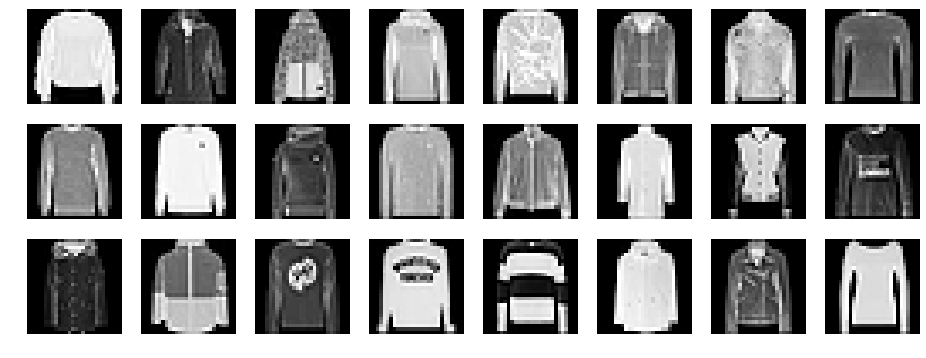

In [886]:
# Visualize training data
plt.figure(figsize=(16,6))
for i in range(24):
    fig = plt.subplot(3, 8, i+1)
    fig.set_axis_off()
    plt.imshow(X_train[i+1], cmap='gray')

# Keras Model

In [902]:
initializer = "random_normal" # random_normal or glorot_uniform
keras_model = k.Sequential([ 
    k.layers.InputLayer(input_shape=(28,28,1)),
    k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    k.layers.MaxPooling2D((3,3)),
    #k.layers.Conv2D(filters=32, kernel_size=3, kernel_initializer=initializer),
    k.layers.Flatten(),
    k.layers.Dense(32, activation="relu", kernel_initializer=initializer),
    k.layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)
])
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                65568     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 65,921
Trainable params: 65,921
Non-trainable params: 0
_________________________________________________________________


In [903]:
# Select only m samples for fast training time during debugging
m = 12000
X = X_train[:m, :, :].reshape((m, 28, 28, 1))
y = y_train[:m].values.reshape(1,m)
# Compile model
keras_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss='binary_crossentropy')
# Train model
history = keras_model.fit(x=X, y=y.flatten(), epochs=10)

Epoch 1/10
375/375 [==============================] - 4s 9ms/step - loss: 0.6344
Epoch 2/10
375/375 [==============================] - 4s 9ms/step - loss: 0.4673
Epoch 3/10
375/375 [==============================] - 4s 9ms/step - loss: 0.4181
Epoch 4/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3956
Epoch 5/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3752
Epoch 6/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3605
Epoch 7/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3514
Epoch 8/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3422
Epoch 9/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3360
Epoch 10/10
375/375 [==============================] - 4s 9ms/step - loss: 0.3270


In [904]:
m = 2000
X = X_test[:m, :, :].reshape((m, 28, 28, 1))
y = y_test[:m].values.reshape(1,m)

predictions = keras_model.predict_classes(X)
accuracy_score(predictions, y.flatten())

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


0.8585

# Custom CNN

In [887]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = tf.raw_ops.Sigmoid(x=Z).numpy()
    cache = A
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = tf.raw_ops.Relu(features=Z).numpy()
    
    cache = A
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = tf.raw_ops.ReluGrad(gradients=dA, features=Z).numpy()
    
    return dZ


def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    A = cache
    dZ = tf.raw_ops.SigmoidGrad(y=A, dy=dA).numpy()
    
    return dZ


def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute loss from aL and y.
    ### START CODE HERE ### (≈ 1 lines of code)
    logprods = np.dot(Y, np.log(AL).T) + np.dot((1-Y), np.log(1-AL).T)
    cost = -1/m*np.sum(logprods)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [913]:
class Layer:
    """
    Interface for layers.
    """
    def __init__(self, input_shape: tuple, output_shape: tuple, trainable=True):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.trainable = trainable
        self.name = self.__class__.__name__ 
        
    def forward(self, A_prev):
        pass
    
    def backward(self, dZ):
        pass
    
    def update_params(self, learning_rate):
        pass
    
    def __str__(self):
        return self.name + " " + str(self.output_shape)
    
    
class Dense(Layer):
    def __init__(self, neurons: int, input_shape: tuple, activation: str):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        neurons (N) -- number of neurons
        input_shape -- (N_prev, m)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
        """
        output_shape = (neurons, input_shape[1])
        super().__init__(input_shape, output_shape)
        self.neurons = neurons
        self.activation = activation
        self.initialize_params()
        
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (N, N_prev)
        self.b -- Biases, numpy array of shape (N, 1)
        '''
        self.W = np.random.randn(self.neurons, self.input_shape[0]) * 0.05
        self.b = np.zeros((self.neurons,1))
        
        
    def forward(self, A_prev):
        """
        Implement the forward propagation for the dense layer with activation function

        Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)

        Returns:
        A -- the output of the activation function, also called the post-activation value 
        
        Defintions:
        self.cache -- tuple of values (A_prev, activation_cache) stored for computing backward propagation efficiently

        """
        Z = np.dot(self.W, A_prev) + self.b
        if self.activation == "sigmoid":
            A, activation_cache = sigmoid(Z)

        elif self.activation == "relu":
            A, activation_cache = relu(Z)

        assert (A.shape == (self.W.shape[0], A_prev.shape[1]))
        self.cache = (A_prev, activation_cache)

        return A
    
    def backward(self, dA):
        """
        Implement the backward propagation for the dense layer with activation function

        Arguments:
        dA -- post-activation gradient for current layer l 
       
        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        
        Definitions:
        self.dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        self.db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, activation_cache = self.cache
        m = A_prev.shape[1]

        if self.activation == "relu":
            dZ = relu_backward(dA, activation_cache)
        elif self.activation == "sigmoid":
            dZ = sigmoid_backward(dA, activation_cache)
        self.dW = np.dot(dZ, A_prev.T)/m
        self.db = np.sum(dZ, axis=1, keepdims=True)/m
        dA_prev = np.dot(self.W.T, dZ)
        return dA_prev
    
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db

    
class Conv2D(Layer):
    def __init__(self, filters: int, filter_size: int, input_shape: tuple, padding="VALID", stride=1):
        """
        Constructor for Conv2D layer.
        
        Arguments:
        filters (C) -- number of filters
        filter_size (f) -- size of filters
        input_shape -- (m, H, W, C)
        """
        output_shape = (input_shape[0], input_shape[1] - filter_size + 1, input_shape[2] - filter_size + 1, filters)
        super().__init__(input_shape, output_shape)
        self.filters = filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        self.initialize_params()
    
    def initialize_params(self):
        '''
        Definitions:
        self.W -- Weights, numpy array of shape (f, f, C_prev, n_C)
        self.b -- Biases, numpy array of shape (1, 1, 1, n_C)
        '''
        self.W = np.random.randn(self.filter_size, self.filter_size, self.input_shape[3], self.filters) * 0.001
        self.b = np.zeros((self.filters))
        

    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution function

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, H_prev, W_prev, C_prev)
        
        Returns:
        Z -- conv output
        """
        
        # Perform convolution
        Z = tf.raw_ops.Conv2D(input=A_prev, filter=self.W, strides=[self.stride]*4, padding=self.padding)
        # Add bias
        Z = tf.raw_ops.BiasAdd(value=Z, bias=self.b)
        
        # Save information in "cache" for the backprop
        self.cache = A_prev
        # Return the output
        return Z.numpy()
    
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution function
        
        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, H, W, C)
        
        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, H_prev, W_prev, C_prev)
                   
        Definitions:
        self.dW -- gradient of the cost with respect to the weights of the conv layer (W)
              numpy array of shape (f, f, C_prev, C)
        self.db -- gradient of the cost with respect to the biases of the conv layer (b)
              numpy array of shape (1, 1, 1, C)
        """

        # Retrieve information from "cache"
        A_prev = self.cache
        m = A_prev.shape[0]
        self.dZ = dZ
        self.A_prev = A_prev
        dA_prev = tf.raw_ops.Conv2DBackpropInput(input_sizes = A_prev.shape, filter = self.W, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()
        self.dW = tf.raw_ops.Conv2DBackpropFilter(input = A_prev, filter_sizes = self.W.shape, out_backprop = dZ, strides=[self.stride]*4, padding=self.padding).numpy()/m
        self.db = np.average(np.sum(dZ, axis=(1,2)), axis=0)
        return dA_prev
    
       
    def update_params(self, learning_rate):
        self.W = self.W-learning_rate*self.dW
        self.b = self.b-learning_rate*self.db
    
    
class Maxpool(Layer):
    def __init__(self, input_shape, pool_size=2):
        self.ksize = [1, pool_size, pool_size, 1]
        self.strides = [1, pool_size, pool_size, 1]
        output_shape = (input_shape[0], input_shape[1]//pool_size, input_shape[2]//pool_size, input_shape[3])
        super().__init__(input_shape, output_shape, False)

        
    def forward(self, A_prev):
        Z = tf.raw_ops.MaxPool(input=A_prev, ksize=self.ksize, strides=self.strides, data_format='NHWC', padding="VALID").numpy()
        self.cache = (A_prev, Z)
        return Z
    
    def backward(self, dZ):
        A_prev, Z = self.cache
        dA_prev = tf.raw_ops.MaxPoolGrad(orig_input=A_prev, orig_output=Z, grad=dZ, ksize=self.ksize, strides=self.strides, padding="VALID", data_format='NHWC').numpy()
        return dA_prev

        
class ReLU(Layer):
    def __init__(self, input_shape):
        output_shape = input_shape
        super().__init__(input_shape, output_shape, False)

      
    def forward(self, Z):
        """
        Implement the RELU function.
        Arguments:
        Z -- Output of the linear layer, of any shape
        Returns:
        A -- Post-activation parameter, of the same shape as Z
        """

        A = tf.raw_ops.Relu(features=Z).numpy()
        self.cache = Z 
        return A

    def backward(self, dA):
        """
        Implement the backward propagation for a single RELU unit.
        Arguments:
        dA -- post-activation gradient, of any shape
        Returns:
        dZ -- Gradient of the cost with respect to Z
        """

        Z = self.cache
        dZ = tf.raw_ops.ReluGrad(gradients=dA, features=Z).numpy()

        return dZ
    
class Flatten(Layer):
    def __init__(self, input_shape):
        m, *shape = input_shape
        output_shape = (m, np.prod(shape))
        super().__init__(input_shape, output_shape, trainable=False)
        
    def forward(self, A_prev):
        m, *shape = A_prev.shape
        self.cache = A_prev.shape
        return A_prev.reshape(m, np.prod(shape))
    
    def backward(self, dZ):
        return dZ.reshape(self.cache)
    

# class Flatten(Layer):
#     def __init__(self, input_shape):
#         m, *shape = input_shape
#         output_shape = (np.prod(shape), m)
#         super().__init__(input_shape, output_shape, trainable=False)
        
#     def forward(self, A_prev):
#         m, *shape = A_prev.shape
#         self.cache = A_prev.shape
#         return A_prev.flatten().reshape(m,np.prod(shape)).T
    
#     def backward(self, dZ):
#         return dZ.T.reshape(self.cache)
    
        
class Model:
    def __init__(self, layers: list):
        self.layers = layers
        
    def fit(self, X, Y, epochs, learning_rate, batch_size, verbose): 
        # Initialize parameters
        history = list()
        m = Y.shape[1]
        chunks = np.linspace(0,m+1,m//batch_size+1).astype(int)
        for epoch in range(epochs):
            for i in range(len(chunks)-1):
                # FORWARD PROP
                Z = X[chunks[i]:chunks[i+1]]
                y = Y[:,chunks[i]:chunks[i+1]]
                for layer in self.layers:
                    Z = layer.forward(Z, y) if layer.name == "knn_differentiable" else layer.forward(Z)
                pred, cost, dA = Z
                # COST FUNCTION
#                 cost = compute_cost(Z, y)
#                 history.append(cost)
                if verbose == 1 and i == 0:
                    print("Cost epoch ", epoch, ": ", cost, sep="")
                
                # BACKWARD PROP
                for layer in reversed(self.layers):
                    dA = layer.backward(dA)

                # UPDATE PARAMS
                for layer in self.layers:
                    if layer.trainable:
                        layer.update_params(learning_rate)

        return history
    
    def predict(self, Z, Y):
        for layer in self.layers:
            Z = layer.forward(Z, Y) if layer.name == "knn_differentiable" else layer.forward(Z)
        return Z[0]
    
    def summary(self):
        print("-"*25)
        for layer in layers:
            print(layer)
            print("-"*25)
            
    def cost(self, Z, Y): 
        for layer in self.layers:
            Z = layer.forward(Z, Y) if layer.name == "knn_differentiable" else layer.forward(Z)
        # COMPUTE COST
        return Z[1]
    
    def gradcheck(self, X, Y, epsilon=1e-7, start=None, end=None):
        self.approx_grads = []
        self.true_grads = []
        for layer in self.layers[start:end]:
            if not layer.trainable:
                continue
            for i in range(layer.W.size):
                i = np.unravel_index(i, layer.W.shape)
                Wi = layer.W[i]
                layer.W[i] = Wi + epsilon
                J1 = self.cost(X, Y)
                layer.W[i] = Wi - epsilon
                J2 = self.cost(X, Y)
                layer.W[i] = Wi
                self.approx_grads.append(-(J1-J2)/(2*epsilon))
                
            for i in range(layer.b.size):
                i = np.unravel_index(i, layer.b.shape)
                bi = layer.b[i]
                layer.b[i] = bi + epsilon
                J1 = self.cost(X, Y)
                layer.b[i] = bi - epsilon
                J2 = self.cost(X, Y)
                layer.b[i] = bi
                self.approx_grads.append((J1-J2)/(2*epsilon))
        
        # FORWARD PROP
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z, Y) if layer.name == "knn_differentiable" else layer.forward(Z)
        # BACKWARD PROP
        pred, cost, dA = Z
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
        
        for layer in self.layers[start:end]:
            if not layer.trainable:
                continue
            self.true_grads = np.concatenate((self.true_grads, layer.dW.flatten(), layer.db.flatten()))
        self.approx_grads = np.array(self.approx_grads)
        self.true_grads = np.array(self.true_grads)
        return np.sqrt(np.sum(np.square(self.true_grads-self.approx_grads)))/(np.sqrt(np.sum(np.square(self.true_grads)))+np.sqrt(np.sum(np.square(self.approx_grads))))
    
        
    
class knn_differentiable(Layer):
    
    def __init__(self, input_shape, num_classes):
        super().__init__(input_shape, num_classes, False)
        
    def forward(self, batch_features, batch_labels):
        self.batch_features = tf.convert_to_tensor(batch_features, dtype=tf.float64)
        self.batch_labels = tf.transpose(tf.convert_to_tensor(batch_labels, dtype=tf.float64))
        with tf.GradientTape() as g:
            g.watch(self.batch_features)
#             norm = tf.reduce_sum(tf.square(self.batch_features), 1, keepdims=True)
#             self.D = tf.maximum(tf.transpose(norm) - 2*tf.matmul(self.batch_features, self.batch_features, False, True) + norm, 0.0)
            dot = tf.matmul(self.batch_features, self.batch_features, False, True)
            length = tf.sqrt(tf.reduce_sum(tf.square(self.batch_features),1,keepdims=True))
            length = tf.matmul(length, length, False, True)
            self.D = 1 - dot/length
            class_1 = tf.reduce_sum(self.batch_labels)
            class_0 = tf.size(self.batch_labels, out_type=tf.float64) - class_1
            self.A = tf.squeeze(tf.stack([tf.matmul(self.D,1-self.batch_labels)/class_0, tf.matmul(self.D,self.batch_labels)/class_1], axis=1))
#             self.S = tf.raw_ops.Softmax(logits=self.A)[:,0]
            m = self.batch_labels.shape[0]
            self.cost = tf.reduce_sum(tf.matmul(tf.transpose(self.batch_labels), self.A))/m
#             self.S = tf.expand_dims(tf.raw_ops.Softmax(logits=tf.negative(self.A))[:,0], axis=1)
#             cost = tf.multiply(tf.divide(-1,m),tf.matmul(self.batch_labels, tf.math.log(self.S), False, True) + tf.matmul((1-self.batch_labels), tf.math.log(1-self.S), False, True))
#             self.S = tf.transpose(tf.divide(tf.transpose(tf.exp(-self.A)),tf.reduce_sum(tf.exp(-self.A), axis=1)))[:,0]
            self.grad = tf.transpose(g.gradient(self.cost, self.batch_features)).numpy()
        return (tf.argmin(self.A, axis=1).numpy(), self.cost.numpy(), self.grad)
            
    def backward(self, dA):
        return dA

# Run Code below for knn layer experiments

In [917]:
# Change below three parameters for experiments 
train_size = 1000
batch_size = 32
learning = 0.001
np.random.seed(0)


times = []
accuracy_lst = [0,0,0,0]
for i in range(1):
    # Select only m samples
    m = train_size
    X = X_train[:m, :, :].reshape((m, 28, 28, 1)).astype("float64")
    y = y_train[:m].values.reshape(1,m).astype("float64")
    # Define the layers of the model
    layers = [
        Conv2D(32, 3, (None, 28, 28, 1)),
        Maxpool((None, 26, 26, 32), pool_size=2),
        Conv2D(64, 3, (None, 13, 13, 32)),
        Maxpool((None, 11, 11, 64), pool_size=2),
        Flatten((None, 5, 5, 64)),
        knn_differentiable((640, None), 2)
    ]

    # Create and train model
    model = Model(layers)
    start_time = time.time()
    history = model.fit(X, y, epochs=10, learning_rate=learning, verbose=1, batch_size=batch_size)
    end_time = time.time()
    ex_time = end_time-start_time
    times.append(ex_time)
    print("Execution Time:", ex_time)
    print()


    # Runs through each testing batch size for the table and gathers accuracies
    batch_sizes = [2000, 1000, batch_size, 15]
    for j in range(len(batch_sizes)):
        m = batch_sizes[j]
        n = 0
        accuracies = []
        for l in range(y_test.values.shape[0]//m):
            X = X_test[n:m, :, :].reshape((m-n, 28, 28, 1)).astype(float)
            y = y_test[n:m].values.reshape(1,m-n).astype(float)
            predictions = model.predict(X, y)
            #print(predictions[:,:10])
            score = accuracy_score(y.flatten(), predictions.flatten().round())
            accuracies.append(score)

            n = m
            m += batch_sizes[j]
        avg_acc = np.average(accuracies)
        accuracy_lst[j] += avg_acc
        print("Accuracy", j+1, "-", avg_acc)
        print()
    print("+"*50, "end of loop", i+1)
    print()

# Output average execution time and average accuracies in a list of the same order as shown in tables
print("\n\n\n")
print("Average Execution Time:", np.average(times), "  ---  ", "Average Accuracies:", np.divide(accuracy_lst, 1))

Cost epoch 0: 0.12142736577478247
Cost epoch 1: 0.04859230922975766
Cost epoch 2: 0.04098897298911212
Cost epoch 3: 0.038222572710722075
Cost epoch 4: 0.03678510541316246
Cost epoch 5: 0.03590919749642409
Cost epoch 6: 0.035310904479965814
Cost epoch 7: 0.03487491580672657
Cost epoch 8: 0.03454352351799012
Cost epoch 9: 0.034284139193106716
Execution Time: 9.761231184005737

Accuracy 1 - 0.645

Accuracy 2 - 0.645

Accuracy 3 - 0.6431451612903226

Accuracy 4 - 0.644110275689223

++++++++++++++++++++++++++++++++++++++++++++++++++ end of loop 1





Average Execution Time: 9.761231184005737   ---   Average Accuracies: [0.645      0.645      0.64314516 0.64411028]
